# Assessing the Validity of the $\Lambda$CDM Model Using Observational Data

We will put limits on two $\lambda$CDM parameters to assess how the theory matches the observational data. Data from two different physical phenomena is used to attain the constraints, type Ia supernova and baryon acoustic oscilations.

# Type Ia Supernova

Type Ia supernovae are used in cosmology as standard candles, meaning their known intrinsic luminosity allows us to determine their distances based on observed brightness. This distance is called the luminosity distance, and under a flat $\Lambda$CDM cosmology, it is given by:
$$D_L(z) = \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}$$
where
$$E(z) = \sqrt{\Omega_\mathrm{M}(1+z)^3 + (1 - \Omega_\mathrm{M})}$$

Here, $z$ is the redshift, $\Omega_\mathrm{M}$ is the matter density parameter, and $H_0$ is the Hubble constant.

To compare with observations, we use data from the SH0ES Team in the form of distance moduli, defined as the difference between the apparent magnitude of the supernova and the magnitude it would have at a distance of 10 parsecs. The distance modulus is related to the luminosity distance by:
$$\mu(z) = 5 \log_{10} \left( \frac{D_L(z)}{10\,\mathrm{pc}} \right)$$

where $D_L$ is in parsecs. This formulation allows us to fit cosmological models to supernova observations and extract constraints on $H_0$ and $\Omega_\mathrm{M}$.


### Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from mpmath import linspace
from scipy import integrate
from IPython.display import display, Math
from seaborn import scatterplot
from tqdm import tqdm
import corner
import multiprocessing

### Importing SH0ES data and putting it in a convenient form

In [12]:
dataS = pd.read_csv("Pantheon+SH0ES.dat", delimiter=' ')
covS = np.loadtxt("Pantheon+SH0ES_STAT+SYS.cov")
x = dataS["zHD"]
y = dataS["MU_SH0ES"]
xerr = dataS["zHDERR"]
yerr = dataS["MU_SH0ES_ERR_DIAG"]
CovMat = covS[1:].reshape(1701, 1701)
CovMatInv = np.linalg.inv(CovMat)

### Defining functions

In [13]:
def DL(z,p):
    H0,OM = p
    c = 299792.458
    integrand = lambda zz: 1 / np.sqrt(OM * (1 + zz)**3 + (1 - OM))
    integral_value, _ = integrate.quad(integrand, 0, z)
    d_lum = (c / H0) * (1 + z) * integral_value * 10**6
    return d_lum

def MU(z,p):
    dist = 5*np.log10(DL(z,p)/10)
    return dist

MUvec = np.vectorize(MU, excluded=[1])

def chi2(p):
    err = np.matmul(np.transpose(MUvec(x,p) - y),np.matmul(CovMatInv,MUvec(x,p) - y))
    return err

### Plotting the data against some arbitrary fit

Text(0, 0.5, 'DM')

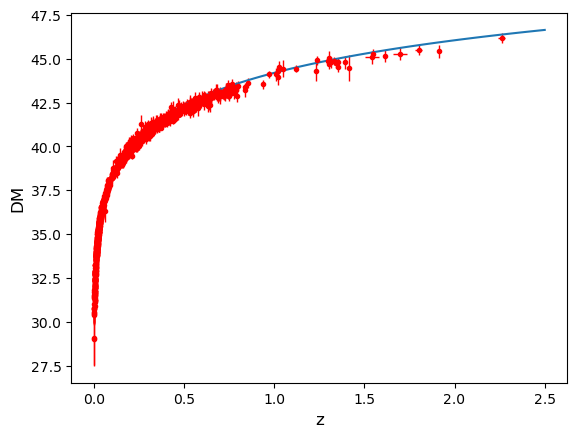

In [14]:
TestPar = np.array([67,0.3])
xt = np.linspace(0.01,2.5,100)
yt = MUvec(xt,TestPar)
plt.errorbar(x,y,xerr=xerr, yerr=yerr,fmt=".r" ,capsize=0,lw=1)
plt.plot(xt,yt)
plt.xlabel(r"z", fontsize=12)
plt.ylabel(r"DM", fontsize=12)

### Searching for an optimal fit using a grid (poor man's optimization)

In [15]:
x2,y2 = np.meshgrid(
    np.linspace(65,80,50),
    np.linspace(0.1,0.5,50)
)
z2 = x2.copy()

for i in range(len(z2)):
    for j in range(len(z2[1])):
        z2[i,j] = chi2(np.array([x2[i,j],y2[i,j]]))

<Figure size 1280x960 with 0 Axes>

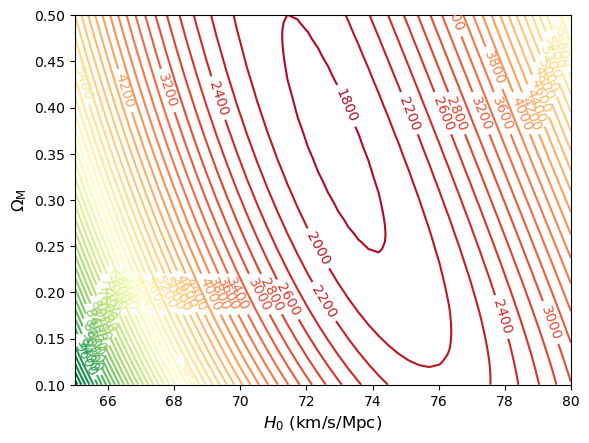

<Figure size 1280x960 with 0 Axes>

In [16]:
contourplot = plt.contour(x2,y2,z2,50,cmap='RdYlGn')
plt.clabel(contourplot, inline = 1, fontsize = 10)
plt.xlabel(r"$H_0$ (km/s/Mpc)", fontsize=12)
plt.ylabel(r"$\Omega_\mathrm{M}$", fontsize=12)
plt.figure(dpi=(200))

In [17]:
x3, y3 = np.meshgrid(
    np.linspace(71, 75, 50),
    np.linspace(0.25, 0.5, 50)
)
z3 = x3.copy()

for i in range(len(z3)):
    for j in range(len(z3[1])):
        z3[i, j] = chi2(np.array([x3[i, j], y3[i, j]]))

<Figure size 1280x960 with 0 Axes>

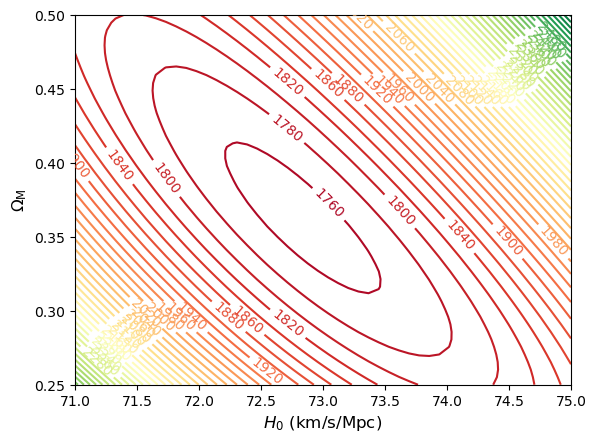

<Figure size 1280x960 with 0 Axes>

In [18]:
contourplot = plt.contour(x3,y3,z3,50,cmap='RdYlGn')
plt.clabel(contourplot, inline = 1, fontsize = 10)
plt.xlabel(r"$H_0$ (km/s/Mpc)", fontsize=12)
plt.ylabel(r"$\Omega_\mathrm{M}$", fontsize=12)
plt.figure(dpi=(200))


### Optimizing using gradient descent

In [19]:
def grad(p):
    dt=10**-5
    g=np.array([
        (chi2(np.array([(p[0]+dt),(p[1])]))-chi2(np.array([(p[0]-dt),(p[1])])))/(2*dt),
        (chi2(np.array([(p[0]),(p[1]+dt)]))-chi2(np.array([(p[0]),(p[1]-dt)])))/(2*dt)
            ])
    return g


def gradient_descent(start, lr, itt):
    p = start.copy()
    history = [np.array([p[0], p[1], chi2(p)])]

    for i in range(itt):
        g = grad(p)
        p = p - lr * g
        history.append(np.array([p[0], p[1], chi2(p)]))


    return history

In [20]:
start=np.array([73.5,0.3])
lr=np.array([1,0.01])*10**-3*1
itt=1000
gdpx,gdpy,gdpz = np.transpose(gradient_descent(start,lr,itt))
print(f"H0 = {gdpx[-1]:.3f}     OmegaM = {gdpy[-1]:.3f}")

H0 = 72.840     OmegaM = 0.361


<Figure size 1280x960 with 0 Axes>

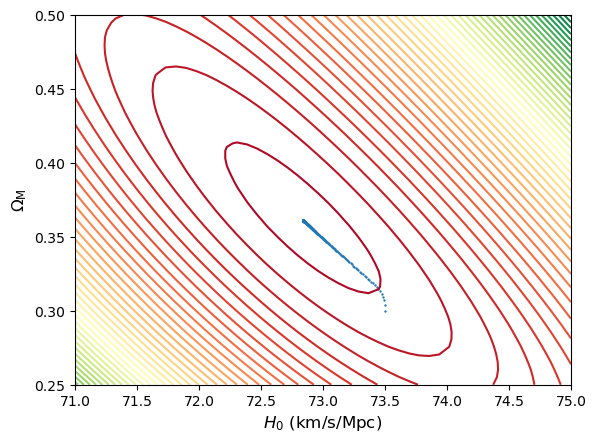

<Figure size 1280x960 with 0 Axes>

In [21]:
plt.contour(x3,y3,z3,50,cmap='RdYlGn')
plt.scatter(gdpx,gdpy,0.5)
plt.clabel(contourplot, inline = 1, fontsize = 10)
plt.xlabel(r"$H_0$ (km/s/Mpc)", fontsize=12)
plt.ylabel(r"$\Omega_\mathrm{M}$", fontsize=12)
plt.figure(dpi=(200))

Text(0, 0.5, 'DM')

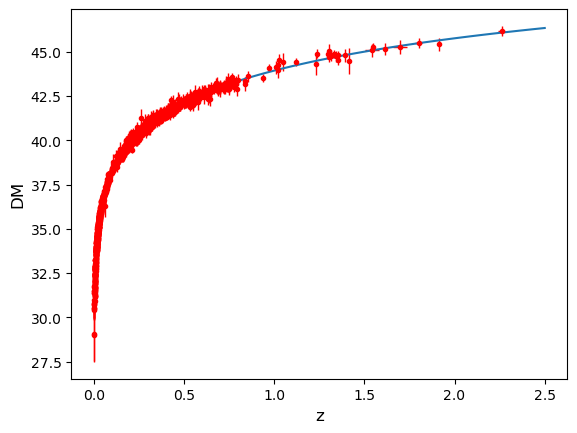

In [22]:
yt = MUvec(xt,np.array([gdpx[-1],gdpy[-1]]))
plt.errorbar(x,y,xerr=xerr, yerr=yerr,fmt=".r" ,capsize=0,lw=1)
plt.plot(xt,yt)
plt.xlabel(r"z", fontsize=12)
plt.ylabel(r"DM", fontsize=12)

### Using MCMC method

In [23]:
def log_prob(params):
    H0, OM = params
    if not (50 < H0 < 90 and 0.1 < OM < 0.5):
        return -np.inf
    return -0.5 * chi2(params)

ndim = 2
nwalkers = 20
p0 = np.array([73.0,0.3]) + np.array([1, 0.01]) * np.random.randn(nwalkers, ndim)

with multiprocessing.Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    sampler.run_mcmc(p0, 1000, progress=True)

samples = sampler.get_chain(discard=500, thin=2, flat=True)


100%|███████████████████████████████████████| 1000/1000 [49:01<00:00,  2.94s/it]


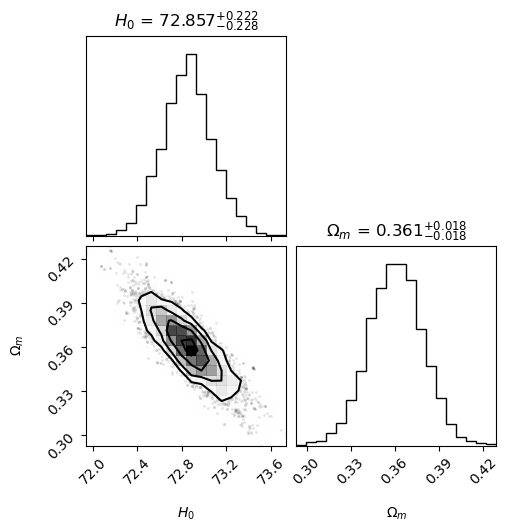

In [24]:
fig = corner.corner(samples, labels=[ r"$H_0$",r"$\Omega_m$"], show_titles=True, title_fmt=".3f")
means = np.mean(samples, axis=0)
stds = np.std(samples, axis=0)
fig.text(0.5, 0.01,"", ha='center', va='bottom', fontsize=12)
plt.show()

# References

$\bullet$ Hogg, David W. "Distance measures in cosmology." arXiv preprint astro-ph/9905116 (1999). https://arxiv.org/pdf/astro-ph/9905116

$\bullet$ The Pantheon+ and SH0ES Teams. (2022). Pantheon+ and SH0ES Data Release [Data repository]. GitHub. https://github.com/PantheonPlusSH0ES/DataRelease